# Emotional State Classifier on a multimodal physiological Dataset.

### Sina Dabiri
### sdabiri3@gatech.edu, sdabiri@emory.edu
### Version 1.0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
import sys
import mne
import time
import pickle
import argparse

In [4]:
from mne.preprocessing import ICA, create_eog_epochs
from scipy.stats import skew, kurtosis
from scipy.signal import argrelextrema
import heartpy as hp
import pprint

In [5]:
# Setting the path for root directory for DEAP dataset, data folder, participants ratings, and EEG channel lists

root_folder = 'C:/Users/sinad/OneDrive - Georgia Institute of Technology/BMED 6517 ML Biosci/Project/emotional_state_classifier/DEAP/DEAP'
data_folder = root_folder + '/data_original'
ratings_csv_path = root_folder + '/Metadata/metadata_csv/participant_ratings.csv'
DEAP_EEG_channels_xlsx_path = root_folder + '/Metadata/DEAP_EEG_channels.xlsx'

In [6]:
npy_folder = os.path.join(os.getcwd(), 'results', 'npy')
print(npy_folder)

for folder in [npy_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\npy


In [7]:
N_trials = 40
N_EEG_electrodes = 32
N_BIPOLAR = 16
sfreq = 128

In [8]:
def epoch_bdf(subject_id):
    npy_plet_path = os.path.join(npy_folder, 's{:02}_plet.npy'.format(subject_id))
    npy_GSR_path = os.path.join(npy_folder, 's{:02}_GSR.npy'.format(subject_id))

    print('\n----------------------------------------------------\n')
    print('extracting bipolar data for Subject {:02}'.format(subject_id))

    bdf_file_name = 's{:02d}.bdf'.format(subject_id)
    bdf_file_path = os.path.join(data_folder, bdf_file_name)

    print('Loading .bdf file {}'.format(bdf_file_path))
    raw = mne.io.read_raw_bdf(bdf_file_path, preload=True, verbose=False).load_data()

    ch_names = raw.ch_names
    eeg_channels = ch_names[:N_EEG_electrodes]
    non_eeg_channels = ch_names[N_EEG_electrodes:]
    stim_ch_name = ch_names[-1]
    stim_channels = [ stim_ch_name ]

    raw_copy = raw.copy()
    raw_stim = raw_copy.pick_channels(stim_channels)
    raw.pick_channels(non_eeg_channels)
    print("Done!")

    #####################################################
    print('Getting events from the status channel')
    events = mne.find_events(raw_stim, stim_channel=stim_ch_name, verbose=True)
    if subject_id<=23:
        # Subject 1-22 and Subjects 23-28 have 48 channels.
        # Subjects 29-32 have 49 channels.
        # For Subjects 1-22 and Subject 23, the stimuli channel has the name 'Status'
        # For Subjects 24-28, the stimuli channel has the name ''
        # For Subjects 29-32, the stimuli channels have the names '-0' and '-1'
        pass
    else:
        # The values of the stimuli channel have to be changed for Subjects 24-32
        # Trigger channel has a non-zero initial value of 1703680 (consider using initial_event=True to detect this event)
        events[:,2] -= 1703680 # subtracting initial value
        events[:,2] = events[:,2] % 65536 # getting modulo with 65536

    print('')
    event_IDs = np.unique(events[:,2])
    for event_id in event_IDs:
        col = events[:,2]
        print('Event ID {} : {:05}'.format(event_id, np.sum( 1.0*(col==event_id) ) ) )
    inds_new_trial = np.where(events[:,2] == 4)[0]
    events_new_trial = events[inds_new_trial,:]
    baseline = (0, 0)
    print('Epoching the data, into [-5sec, +60sec] epochs')
    epochs = mne.Epochs(raw, events_new_trial, event_id=4, tmin=-5.0, tmax=60.0, picks=non_eeg_channels, baseline=baseline, preload=True)

    
    epochs_copy = epochs.copy()
    print('Downsampling epoched data to 128Hz')
    epochs_downsampled = epochs_copy.resample(sfreq)

    data = epochs.get_data()
    data_downsampled = epochs_downsampled.get_data()
    print('Original epoched data shape: {}'.format(data.shape))
    print('Downsampled epoched data shape: {}'.format(data_downsampled.shape))

    #############################

    ratings = pd.read_csv(ratings_csv_path)
    is_subject =  (ratings['Participant_id'] == subject_id)
    ratings_subj = ratings[is_subject]
    trial_pick_indices = []
    print('\nPreparing EEG trial reordering, from presentation order, to video (Experiment_id) order')
    for i in range(N_trials):
        exp_id = i+1
        is_exp = (ratings['Experiment_id'] == exp_id)
        trial_id = ratings_subj[is_exp]['Trial'].values[0]
        trial_pick_indices.append(trial_id - 1)
        print('Picking source (raw) trial #{:02} to fill target (npy) trial #{:02} | Experiment_id: {:02}'.format(trial_id, exp_id, exp_id))

    #############################    

    # Store clean and reordered data to numpy array
    epoch_duration = data_downsampled.shape[-1]
    data_npy = np.zeros((N_trials, N_BIPOLAR, epoch_duration))
    print(data_npy.shape)
    print('\nStoring the final EEG data in a numpy array of shape {}'.format(data_npy.shape))
    print(len(trial_pick_indices))
    for trial_source, trial_target in zip(trial_pick_indices, range(N_trials)):
        data_trial = data_downsampled[trial_source]
        # print(data_trial.shape)
        # print(data_npy[trial_target,:,:].shape)
        data_npy[trial_target,:,:] = data_trial.copy()
    print('Saving the final EEG data in a .npy file')
    np.save(npy_plet_path, data_npy[:,13,:])
    np.save(npy_GSR_path, data_npy[:,8,:])

    print('Raw physiological data has been epoched, downsampled, trial-reordered and channel-reordered.')
    print('Finished.') 

In [9]:
subject_id = 1

epoch_bdf(subject_id)


----------------------------------------------------

extracting bipolar data for Subject 01
Loading .bdf file C:/Users/sinad/OneDrive - Georgia Institute of Technology/BMED 6517 ML Biosci/Project/emotional_state_classifier/DEAP/DEAP/data_original\s01.bdf
Done!
Getting events from the status channel
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
13760 events found
Event IDs: [1 2 3 4 5 6 7]

Event ID 1 : 162.0
Event ID 2 : 002.0
Event ID 3 : 040.0
Event ID 4 : 040.0
Event ID 5 : 040.0
Event ID 6 : 13475.0
Event ID 7 : 001.0
Epoching the data, into [-5sec, +60sec] epochs
Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 33281 original time points ...
0 bad epochs dropped
Downsampling epoched data to 128Hz
Original epoched data shape: (40, 16, 33281)
Downsa

C:\Users\sinad\AppData\Local\Temp\ipykernel_17968\1862052990.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trial_id = ratings_subj[is_exp]['Trial'].values[0]


In [10]:
def extract_HR_features(subject_id,trial_num):

    trial = trial_num

    feats_folder = os.path.join(os.getcwd(), 'results', 'features_new')

    plet_path = os.path.join(feats_folder, 's{:02}_plet.npy'.format(subject_id))
    if os.path.exists(plet_path):
        print('\nFeatures are already saved.\nSkipping data extraction for Subject {:02}'.format(subject_id))

    print('\nExtracting features for Subject {:02}'.format(subject_id))

    # Load data
    plet_file_path = os.path.join(npy_folder, 's{:02d}_plet.npy'.format(subject_id))
    print('Loading preprocessed Plethysmograph from .npy file {}\n'.format(plet_path))
    plet_data = np.load(plet_file_path)

    wd, m = hp.process(plet_data[trial,:], sample_rate = sfreq)

    # set large figure
    # plt.figure(figsize=(7,4))

    # call plotter
    hp.plotter(wd, m, figsize=(7,3))
    plt.show()
    
    return m


Extracting features for Subject 01
Loading preprocessed Plethysmograph from .npy file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\features_new\s01_plet.npy



C:\Users\sinad\anaconda3\envs\emotional_state_env\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


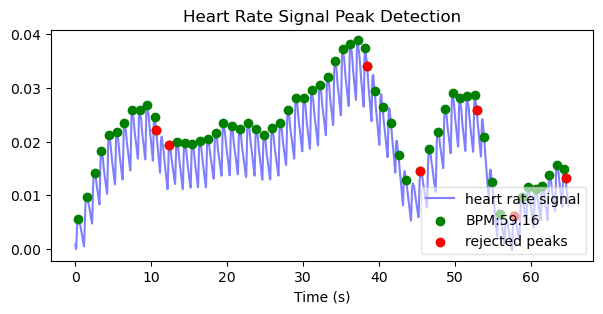

bpm: 59.155681
ibi: 1014.272837
sdnn: 71.712838
sdsd: 58.072320
rmssd: 80.236414
pnn20: 0.695652
pnn50: 0.391304
hr_mad: 39.062500
sd1: 56.694517
sd2: 72.648937
s: 12939.580440
sd1/sd2: 0.780390
breathingrate: 0.233333


In [11]:
trial_num = 1

HR_feat = extract_HR_features(subject_id, trial_num)
for measure in HR_feat.keys():
    print('%s: %f' %(measure, HR_feat[measure]))

In [12]:
def extract_GSR_features(subject_id,trial_num):

    trial = trial_num

    feats_folder = os.path.join(os.getcwd(), 'results', 'features_new')

    GSR_path = os.path.join(feats_folder, 's{:02}_GSR.npy'.format(subject_id))
    if os.path.exists(GSR_path):
        print('\nFeatures are already saved.\nSkipping data extraction for Subject {:02}'.format(subject_id))

    print('\nExtracting features for Subject {:02}'.format(subject_id))

    # Load data
    GSR_file_path = os.path.join(npy_folder, 's{:02d}_GSR.npy'.format(subject_id))
    print('Loading preprocessed GSR from .npy file {}\n'.format(GSR_path))
    GSR_data = np.load(GSR_file_path)
    
    plt.figure(figsize=(7,3))
    plt.plot(GSR_data[trial,:])
    plt.show()
    
    features = statistics_feature(GSR_data)
    return features


In [13]:
def statistics_feature(data):
    mean = np.mean(data)
    std = np.std(data)
    Skew = skew(data)
    kurt = kurtosis(data)
    mean_fst_absdiff = np.mean(abs(np.diff(data)))
    mean_snd_absdiff = np.mean(abs(np.diff(np.diff(data))))
    mean_fst_diff = np.mean(np.diff(data))
    mean_snd_diff = np.mean(np.diff(np.diff(data)))
    mean_neg_diff = np.mean(np.diff(data)[np.where(np.diff(data)<0)])
    proportion_neg_diff = len(np.where(np.diff(data)<0)[0])/(len(np.diff(data)))
    number_local_min = len(argrelextrema(data,np.less)[0])
    number_local_max = len(argrelextrema(data,np.greater)[0])
    f1 = [mean,std,Skew,kurt]
    f2 = [mean_fst_absdiff,mean_snd_absdiff,mean_fst_diff,mean_snd_diff,mean_neg_diff,proportion_neg_diff]
    f3 = [number_local_min,number_local_max]
    f = f1+f2+f3
    names = ['meam','std','skew','kurtosis','me.1absdf','me.2absdf','me.1df','me.2df','me.negdf','ro.negdf','num.argmi','num.argma']
    GSR_features = dict(zip(names, f))
    return GSR_features


Extracting features for Subject 01
Loading preprocessed GSR from .npy file C:\Users\sinad\OneDrive - Georgia Institute of Technology\BMED 6517 ML Biosci\Project\emotional_state_classifier\BMED_6517_emotional_state_classifier\results\features_new\s01_GSR.npy



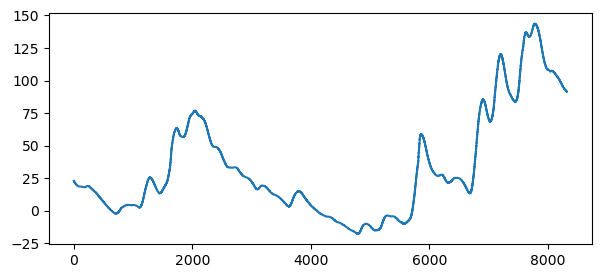

meam:  -87.59641822091699
std:  294.0487151490621
skew:  [-2.39560108 -2.40043561 -2.41145399 ... -1.65117167 -1.65221311
 -1.65231884]
kurtosis:  [5.6887228  5.7144277  5.76456597 ... 7.02355337 7.03162694 7.02968144]
me.1absdf:  0.14531665260398208
me.2absdf:  0.2102777526499432
me.1df:  -0.013164466971615543
me.2df:  -5.868019764147356e-06
me.negdf:  -0.13358709463732268
ro.negdf:  4934.625
num.argmi:  94144
num.argma:  95237


In [14]:
gsr_feat = extract_GSR_features(subject_id, trial_num)
#pprint.pprint(gsr_feat)

for measure in gsr_feat.keys():
    print('%s: ' %(measure),gsr_feat[measure])

In [15]:
from mne.preprocessing import ICA, create_eog_epochs

In [16]:
root_folder = 'C:/Users/sinad/OneDrive - Georgia Institute of Technology/BMED 6517 ML Biosci/Project/emotional_state_classifier/DEAP/DEAP/data_original'
ratings_csv_path = 'C:/Users/sinad/OneDrive - Georgia Institute of Technology/BMED 6517 ML Biosci/Project/emotional_state_classifier/DEAP/DEAP/Metadata/metadata_csv/participant_ratings.csv' # os.path.join(os.getcwd(), 'metadata_csv', 'participant_ratings.csv')
DEAP_EEG_channels_xlsx_path = 'C:/Users/sinad/OneDrive - Georgia Institute of Technology/BMED 6517 ML Biosci/Project/emotional_state_classifier/DEAP/DEAP/Metadata/DEAP_EEG_channels.xlsx'

In [17]:
N_trials = 40
N_EEG_electrodes = 32
N_ICA = N_EEG_electrodes - 1

In [18]:
ICA_components_folder = os.path.join(os.getcwd(), 'results', 'ICA_components')
ICA_models_folder = os.path.join(os.getcwd(), 'results', 'ICA_models')
PSD_folder = os.path.join(os.getcwd(), 'results', 'PSD')
mneraw_as_pkl_folder = os.path.join(os.getcwd(), 'results', 'pkl')
npy_folder = os.path.join(os.getcwd(), 'results', 'npy')

In [23]:
for folder in [ICA_components_folder, ICA_models_folder, PSD_folder, mneraw_as_pkl_folder, npy_folder]:
	if not os.path.exists(folder):
		os.makedirs(folder, exist_ok=True)

def clean_bdf(subject_id):

	npy_path = os.path.join(npy_folder, 's{:02}.npy'.format(subject_id))
	if os.path.exists(npy_path):
		print('\nFile has already been preprocessed.\nSkipping EEG .bdf preprocessing for Subject {:02}'.format(subject_id))
		return 0

	print('\n----------------------------------------------------\n')
	print('Cleaning data for Subject {:02}'.format(subject_id))

	bdf_file_name = 's{:02d}.bdf'.format(subject_id)
	bdf_file_path = os.path.join(root_folder, bdf_file_name)
	
	print('Loading .bdf file {}'.format(bdf_file_path))
	raw = mne.io.read_raw_bdf(bdf_file_path, preload=True, verbose=False).load_data()
	ch_names = raw.ch_names
	eeg_channels = ch_names[:N_EEG_electrodes]
	non_eeg_channels = ch_names[N_EEG_electrodes:]
	stim_ch_name = ch_names[-1]
	stim_channels = [ stim_ch_name ]

	raw_copy = raw.copy()
	raw_stim = raw_copy.pick_channels(stim_channels)
	raw.pick_channels(eeg_channels)
	print('Setting montage with BioSemi32 electrode locations')
	biosemi_montage = mne.channels.make_standard_montage(kind='biosemi32', head_size=0.095)
	raw.set_montage(biosemi_montage)
	print('Applying notch filter (50Hz) and bandpass filter (4-45Hz)')
	raw.notch_filter(np.arange(50, 251, 50), n_jobs=1, fir_design='firwin')
	raw.filter(4, 45, fir_design='firwin')

	####################################
	# https://mne.tools/dev/generated/mne.set_eeg_reference.html
	# https://mne.tools/stable/auto_tutorials/preprocessing/plot_55_setting_eeg_reference.html
	# https://mne.tools/dev/auto_examples/preprocessing/plot_rereference_eeg.html
	# http://predictablynoisy.com/mne-python/auto_tutorials/plot_eeg_erp.html

	# **************
	# No reference. This assumes that the EEG has already been referenced properly.
	# This explicitly prevents MNE from adding a default EEG reference.
	# raw.set_eeg_reference([])
	# **************
	# Re-reference from an average reference to the mean of channels T7 and T8.
	# raw.set_eeg_reference(['T7', 'T8'])
	# **************
	# Average reference. This is normally added by default, but can also be added explicitly.
	print('Re-referencing all electrodes to the common average reference')
	raw.set_eeg_reference()
	#####################################################
	print('Getting events from the status channel')
	events = mne.find_events(raw_stim, stim_channel=stim_ch_name, verbose=True)
	if subject_id<=23:
		# Subject 1-22 and Subjects 23-28 have 48 channels.
		# Subjects 29-32 have 49 channels.
		# For Subjects 1-22 and Subject 23, the stimuli channel has the name 'Status'
		# For Subjects 24-28, the stimuli channel has the name ''
		# For Subjects 29-32, the stimuli channels have the names '-0' and '-1'
		pass
	else:
		# The values of the stimuli channel have to be changed for Subjects 24-32
		# Trigger channel has a non-zero initial value of 1703680 (consider using initial_event=True to detect this event)
		events[:,2] -= 1703680 # subtracting initial value
		events[:,2] = events[:,2] % 65536 # getting modulo with 65536
	
	print('')
	event_IDs = np.unique(events[:,2])
	for event_id in event_IDs:
		col = events[:,2]
		print('Event ID {} : {:05}'.format(event_id, np.sum( 1.0*(col==event_id) ) ) )
	inds_new_trial = np.where(events[:,2] == 4)[0]
	events_new_trial = events[inds_new_trial,:]
	baseline = (0, 0)
	print('Epoching the data, into [-5sec, +60sec] epochs')
	epochs = mne.Epochs(raw, events_new_trial, event_id=4, tmin=-5.0, tmax=60.0, picks=eeg_channels, baseline=baseline, preload=True)

	print('Fitting ICA to the epoched data, using {} ICA components'.format(N_ICA))
	ica = ICA(n_components=N_ICA, method='fastica', random_state=23)
	ica.fit(epochs)
	ICA_model_file = os.path.join(ICA_models_folder, 's{:02}_ICA_model.pkl'.format(subject_id))
	with open(ICA_model_file, 'wb') as pkl_file:
		pickle.dump(ica, pkl_file)
	# ica.plot_sources(epochs)
	print('Plotting ICA components')
	fig = ica.plot_components()
	cnt = 1
	for fig_x in fig:
		print(fig_x)
		fig_ICA_path = os.path.join(ICA_components_folder, 's{:02}_ICA_components_{}.png'.format(subject_id, cnt))
		fig_x.savefig(fig_ICA_path)
		cnt += 1
	# Inspect frontal channels to check artifact removal 
	# ica.plot_overlay(raw, picks=['Fp1'])
	# ica.plot_overlay(raw, picks=['Fp2'])
	# ica.plot_overlay(raw, picks=['AF3'])
	# ica.plot_overlay(raw, picks=['AF4'])
	N_excluded_channels = len(ica.exclude)
	print('Excluding {:02} ICA component(s): {}'.format(N_excluded_channels, ica.exclude))
	epochs_clean = ica.apply(epochs.copy())

	#############################

	print('Plotting PSD of epoched data')
	fig = epochs_clean.plot_psd(fmin=4, fmax=45, area_mode='range', average=False, picks=eeg_channels, spatial_colors=True)
	fig_PSD_path = os.path.join(PSD_folder, 's{:02}_PSD.png'.format(subject_id))
	fig.savefig(fig_PSD_path)

	print('Saving ICA epoched data as .pkl file')
	mneraw_pkl_path = os.path.join(mneraw_as_pkl_folder, 's{:02}.pkl'.format(subject_id))
	with open(mneraw_pkl_path, 'wb') as pkl_file:
		pickle.dump(epochs_clean, pkl_file)

	epochs_clean_copy = epochs_clean.copy()
	print('Downsampling epoched data to 128Hz')
	epochs_clean_downsampled = epochs_clean_copy.resample(sfreq=128.0)

	print('Plotting PSD of epoched downsampled data')
	fig = epochs_clean_downsampled.plot_psd(fmin=4, fmax=45, area_mode='range', average=False, picks=eeg_channels, spatial_colors=True)
	fig_PSD_path = os.path.join(PSD_folder, 's{:02}_PSD_downsampled.png'.format(subject_id))
	fig.savefig(fig_PSD_path)

	data = epochs_clean.get_data()
	data_downsampled = epochs_clean_downsampled.get_data()
	print('Original epoched data shape: {}'.format(data.shape))
	print('Downsampled epoched data shape: {}'.format(data_downsampled.shape))
	
	###########################################
	
	EEG_channels_table = pd.read_excel(DEAP_EEG_channels_xlsx_path)
	EEG_channels_geneva = EEG_channels_table['Channel_name_Geneva'].values
	channel_pick_indices = []
	print('\nPreparing EEG channel reordering to comply with the Geneva order')
	for (geneva_ch_index, geneva_ch_name) in zip(range(N_EEG_electrodes), EEG_channels_geneva):
		bdf_ch_index = eeg_channels.index(geneva_ch_name)
		channel_pick_indices.append(bdf_ch_index)
		print('Picking source (raw) channel #{:02} to fill target (npy) channel #{:02} | Electrode position: {}'.format(bdf_ch_index + 1, geneva_ch_index + 1, geneva_ch_name))

	ratings = pd.read_csv(ratings_csv_path)
	is_subject =  (ratings['Participant_id'] == subject_id)
	ratings_subj = ratings[is_subject]
	trial_pick_indices = []
	print('\nPreparing EEG trial reordering, from presentation order, to video (Experiment_id) order')
	for i in range(N_trials):
		exp_id = i+1
		is_exp = (ratings['Experiment_id'] == exp_id)
		trial_id = ratings_subj[is_exp]['Trial'].values[0]
		trial_pick_indices.append(trial_id - 1)
		print('Picking source (raw) trial #{:02} to fill target (npy) trial #{:02} | Experiment_id: {:02}'.format(trial_id, exp_id, exp_id))
	
	# Store clean and reordered data to numpy array
	epoch_duration = data_downsampled.shape[-1]
	data_npy = np.zeros((N_trials, N_EEG_electrodes, epoch_duration))
	print('\nStoring the final EEG data in a numpy array of shape {}'.format(data_npy.shape))
	for trial_source, trial_target in zip(trial_pick_indices, range(N_trials)):
		data_trial = data_downsampled[trial_source]
		data_trial_reordered_channels = data_trial[channel_pick_indices,:]
		data_npy[trial_target,:,:] = data_trial_reordered_channels.copy()
	print('Saving the final EEG data in a .npy file')
	np.save(npy_path, data_npy)
	
	print('Raw EEG has been filtered, common average referenced, epoched, artifact-rejected, downsampled, trial-reordered and channel-reordered.')
	print('Finished.')

In [24]:
if __name__=='__main__':
	parser = argparse.ArgumentParser(description="Preprocessing the DEAP dataset's .bdf files")
	parser.add_argument('--subject_id', type=int, default=1, help="Subject ID")
	args = parser.parse_args()

	clean_bdf(args.subject_id)

usage: ipykernel_launcher.py [-h] [--subject_id SUBJECT_ID]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\sinad\AppData\Roaming\jupyter\runtime\kernel-00ac76a2-f5a0-438d-bf9d-c1e6f919ec6f.json


SystemExit: 2